### 3. Наглядный пример регуляризации логистической регрессии

In [2]:
#from _future_ import division, print_function

# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [3]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [4]:
# loading data
data = pd.read_csv(
    DATA_PATH + "microchip_tests.txt",
    header=None,
    names=("test1", "test2", "released")
)
# getting some info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [5]:
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [8]:
data.tail()

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


In [7]:
data.describe()

,test1,test2,released
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


In [16]:
X = data.iloc[:, :2].values
X[:5]

array([[ 0.051267,  0.69956 ],
       [-0.092742,  0.68494 ],
       [-0.21371 ,  0.69225 ],
       [-0.375   ,  0.50219 ],
       [-0.51325 ,  0.46564 ]])

In [18]:
data.iloc[:5, :2]

,test1,test2
0,0.051267,0.69956
1,-0.092742,0.68494
2,-0.213710,0.69225
3,-0.375000,0.50219
4,-0.513250,0.46564


In [19]:
data.iloc[:5, 2]

0    1
1    1
2    1
3    1
4    1
Name: released, dtype: int64

Сохраним обучающую выборку и метки целевого класса в отдельных массивах NumPy.

In [22]:
X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

In [26]:
X[y == 1, 0][:5]

array([ 0.051267, -0.092742, -0.21371 , -0.375   , -0.51325 ])

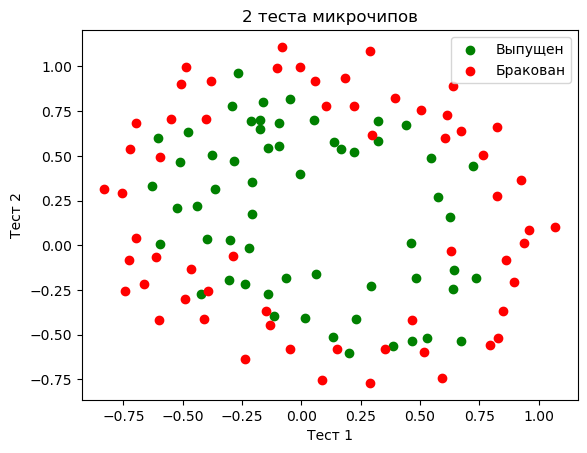

In [30]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel('Тест 1')
plt.ylabel('Тест 2')
plt.title('2 теста микрочипов')
plt.legend()

Определяем функцию для отображения разделяющей кривой классификатора

In [45]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step))
    
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Полиномиальными признаками до степени $d$ для двух переменных $x_1$ и $x_2$ мы называем следующие:


$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} = \{x_1^ix_2^j\}_{i+j \leq d, i,j \in \mathbb{N}}$


Например, для $d=3$ это будут следующие признаки:


$\large 1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$

Функция np.meshgrid применяется для формирования **двумерной сетки координат x и y**.

Она позволяет трансформировать **одномерные массивы** в **двумерные матрицы**, создавая универсальную сетку для пар координат x-y, необходимую для ряда функций.

In [46]:
x_ex = np.linspace(0, 1, 3)  # Генерируем три точки в диапазоне от 0 до 1
y_ex = np.linspace(0, 1, 2)  # Генерируем две точки в диапазоне от 0 до 1

# Создаем сетку
X_ex, Y_ex = np.meshgrid(x_ex, y_ex)

# Отображаем полученные массивы X и Y
print("x_ex:", x_ex)
print()
print("y_ex:", y_ex)
print()
print("X:", X_ex)
print()
print("Y:", Y_ex)

x_ex: [0.  0.5 1. ]

y_ex: [0. 1.]

X: [[0.  0.5 1. ]
 [0.  0.5 1. ]]

Y: [[0. 0. 0.]
 [1. 1. 1.]]


Создадим объект sklearn, который добавит в матрицу $X$ полиномиальные признаки вплоть до степени 7 и обучим логистическую регрессию с параметром регуляризации $C = 10^{-2}$. Изобразим разделяющую границу.

In [57]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

PolynomialFeatures — это класс, который преобразует исходный набор признаков в новый, добавляя полиномиальные комбинации признаков вплоть до заданной степени.

degree=7:
Указывает, что полиномиальные признаки будут включать все степени от 1 до 7.

fit_transform(X):
1) Подгоняет параметры преобразования на данных X и сразу преобразует их.
2) Если X — это двумерный массив размерности (n,m), где n — число примеров, а m — число признаков, то fit_transform добавляет дополнительные столбцы с полиномиальными комбинациями.

Новый массив X_poly:

1) Это массив с дополнительными полиномиальными признаками. Его размер будет (n,количество новых признаков), где количество новых признаков зависит от степени degree и числа исходных признаков m.

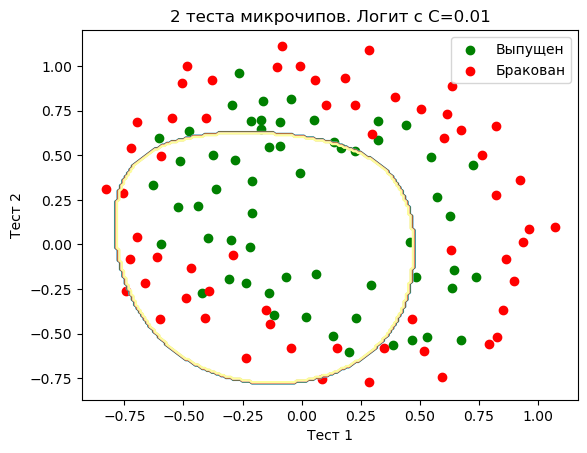

In [62]:
C = 1e-2 #параметр регуляризации
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title("2 теста микрочипов. Логит с C=0.01")
plt.legend()

Также проверим долю правильных ответов классификатора на обучающей выборке. Видим, что регуляризация оказалась слишком сильной, и модель "недообучилась". Доля правильных ответов классификатора на обучающей выборке оказалась равной 0.627.

In [59]:
print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.627


Увеличим $C$ до 1. Тем самым мы ослабляем регуляризацию, теперь в решении значения весов логистической регрессии могут оказаться больше (по модулю), чем в прошлом случае. Теперь доля правильных ответов классификатора на обучающей выборке – 0.831.

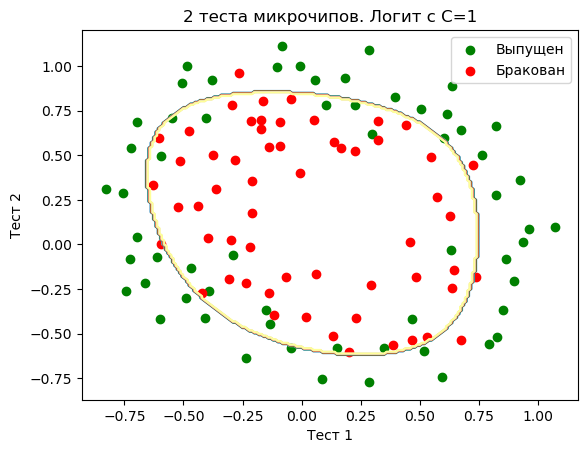

In [60]:
C = 1
logit = LogisticRegression(C=C, random_state=17, n_jobs=-1)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 0, 0], X[y == 0, 1], c='green', label='Выпущен')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=1')
plt.legend()

In [61]:
print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.831


Еще увеличим $C$ – до 10 тысяч. Теперь регуляризации явно недостаточно, и мы наблюдаем переобучение. Можно заметить, что в прошлом случае (при $C$=1 и "гладкой" границе) доля правильных ответов модели на обучающей выборке не намного ниже, чем в 3 случае, зато на новой выборке, можно себе представить, 2 модель сработает намного лучше.
Доля правильных ответов классификатора на обучающей выборке – 0.873.



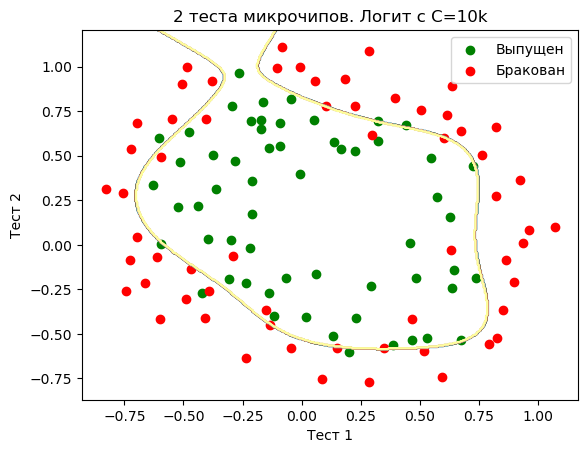

In [63]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17, n_jobs=-1)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel('Тест 1')
plt.ylabel('Тест 2')
plt.title('2 теста микрочипов. Логит с C=10k')
plt.legend()

In [64]:
print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.881


Чтоб обсудить результаты, перепишем формулу для функционала, который оптимизируется в логистической регрессии, в таком виде:

$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$
где


$\mathcal{L}$ – логистическая функция потерь, просуммированная по всей выборке
$C$ – обратный коэффициент регуляризации (тот самый $C$ в sklearn-реализации LogisticRegression)

Промежуточные выводы:


1) Чем больше параметр $C$, тем более сложные зависимости в данных может восстанавливать модель (интуитивно $C$ соответствует "сложности" модели (model capacity))
2) Если регуляризация слишком сильная (малые значения $C$), то решением задачи минимизации логистической функции потерь может оказаться то, когда многие веса занулились или стали слишком малыми. Еще говорят, что модель недостаточно "штрафуется" за ошибки (то есть в функционале $J$ "перевешивает" сумма квадратов весов, а ошибка $\mathcal{L}$ может быть относительно большой). В таком случае модель окажется недообученной (1 случай)
3) Наоборот, если регуляризация слишком слабая (большие значения $C$), то решением задачи оптимизации может стать вектор $w$ с большими по модулю компонентами. В таком случае больший вклад в оптимизируемый функционал $J$ имеет $\mathcal{L}$ и, вольно выражаясь, модель слишком "боится" ошибиться на объектах обучающей выборки, поэтому окажется переобученной (3 случай), то, какое значение $C$ выбрать, сама логистическая регрессия "не поймет" (или еще говорят "не выучит"), то есть это не может быть определено решением оптимизационной задачи, которой является логистическая регрессия (в отличие от весов $w$). Так же точно, дерево решений не может "само понять", какое ограничение на глубину выбрать (за один процесс обучения). Поэтому $C$ – это гиперпараметр модели, который настраивается на кросс-валидации, как и max_depth для дерева.

#### Настройка параметра регуляризации

Теперь найдем оптимальное (в данном примере) значение параметра регуляризации $C$. Сделать это можно с помощью LogisticRegressionCV – перебора параметров по сетке с последующей кросс-валидацией. Этот класс создан специально для логистической регрессии (для нее известны эффективные алгоритмы перебора параметров), для произвольной модели мы бы использовали GridSearchCV, RandomizedSearchCV или, например, специальные алгоритмы оптимизации гиперпараметров, реализованные в hyperopt.

In [67]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       6.45088409e+02, 6.60144909e+02, 6.75552832e+02, 6.91320378e+02,
       7.07455942e+02, 7.23968114e+02, 7.40865683e+02, 7.58157646e+02,
       7.75853206e+02, 7.93961785e+02, 8.12493021e+02, 8.31456781e+02,
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, verbose=1)

In [69]:
round(logit_searcher.score(X_poly, y), 3)

0.839